## SCC5977 - Aprendizado de Máquina para Séries Temporais (2023) - Trabalho Prático

## *Dynamic Time Warping* como metodologia para treinamento de modelos de previsão para Temperatura da Superfície Oceânica

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
from netuno import SSTHelper

Os dados de interesse se tratam de séries temporais de temperatura da superfície ocânica disponibilizadas pela NOAA (National Oceanic and Atmospheric Administration). Mais especificamente, utilizamos os dados da base de reconstrução de temperatura da superfície oceÇanica (versão 5) disponibilizada para a comunidade específica. Os detalhes, bem como a documentação dos dados podem ser verificados [aqui](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html).

Os dados estão em um arquivo netCDF, os quais são amplamente utilizados na disponibilização de dados para a comunidade científica, com destaque para a comunidade de ciências da Terra, devido à sua capacidade de armazenar metadados estruturados que permitem a sua completa descrição. Assim, informações como descrição, unidades e domínio das variáveis, origem dos dados, autores responsáveis pela sua disponibilização, comentários e etc. podem ser adicionadas como emtadados no mesmo arquivo que contém os dados. 

Utilizando o pacote `netCDF4` é possível verificar os metadados para o conjunto de dados que iremos estudar.

In [10]:
fp = 'dados/sst.mnmean.nc'

A biblioteca xarray permite a fácil conversão dos dados das séries temporais armazenados no netcdf para um pandas dataframe.

In [11]:
ds = SSTHelper.load_dataset(fp)
df = SSTHelper.load_dataframe(ds)

In [12]:
df.head()

,lat,lon,time,nbnds,time_bnds,sst
0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8
6,88.0,0.0,1854-04-01,0,9.969210e+36,-1.8
8,88.0,0.0,1854-05-01,0,9.969210e+36,-1.8


Reiniciando-se os indexadores do *dataframe* e obtendo os dados a partir de uma única forma de medição (nbnds), obtém-se de mais fácil indexação para posterior análise.

In [13]:
df = df.reset_index()
df = df[df['nbnds'] == 0] # Garante que há apenas uma medição por área por tempo
df.head()

,index,lat,lon,time,nbnds,time_bnds,sst
0,0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
1,2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
2,4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8
3,6,88.0,0.0,1854-04-01,0,9.969210e+36,-1.8
4,8,88.0,0.0,1854-05-01,0,9.969210e+36,-1.8


Para a análise e aplicação proposta no presente projeto, os dados de importância são a localidade da informação de temperatura da superfície oceânica (*latidude* [lat] e *longitude* [lon]), o valor da temperatura média mensal em graus Celsius (*sst*) e a data referente à medição da média mensal (*time*). Os autores do trabalho de disponibilização dos dados optaram por referenciar cada mês por seu primeiro dia. Isso é uma boa prática por evita divergências ao utilizar-se o último dia de cada mês, já que estes diferem a depender do mês em questão. Assim, para cada localidade na resolução disponível e para cada mês na série histórica, tem-se a média mensal da temperatura da superfície oceânica dada por *sst*. Os dados aqui utilizados vão de janeiro de 1854 a outurbo de 2023.

In [14]:
df['time']

0          1854-01-01
1          1854-02-01
2          1854-03-01
3          1854-04-01
4          1854-05-01
              ...    
32648755   2023-06-01
32648756   2023-07-01
32648757   2023-08-01
32648758   2023-09-01
32648759   2023-10-01
Name: time, Length: 32648760, dtype: datetime64[ns]

In [15]:
df.shape

(32648760, 7)

No módulo `netuno` foi implementada uma função para criar um gráfico `Basemap` com as temperaturas da superfície oceânica para uma determinada data na função `sst_basemap`. Ela recebe a estrutura de dados netCDF4 para o cojunto de dados de SST e um indexador para a data (0 seria o mês mais antigo de registro, 1 seria o mês imediatamente seguinte, e assim por diante) e imprime um mapa de calor com intensidade demarcada pela SST local na data indicada.

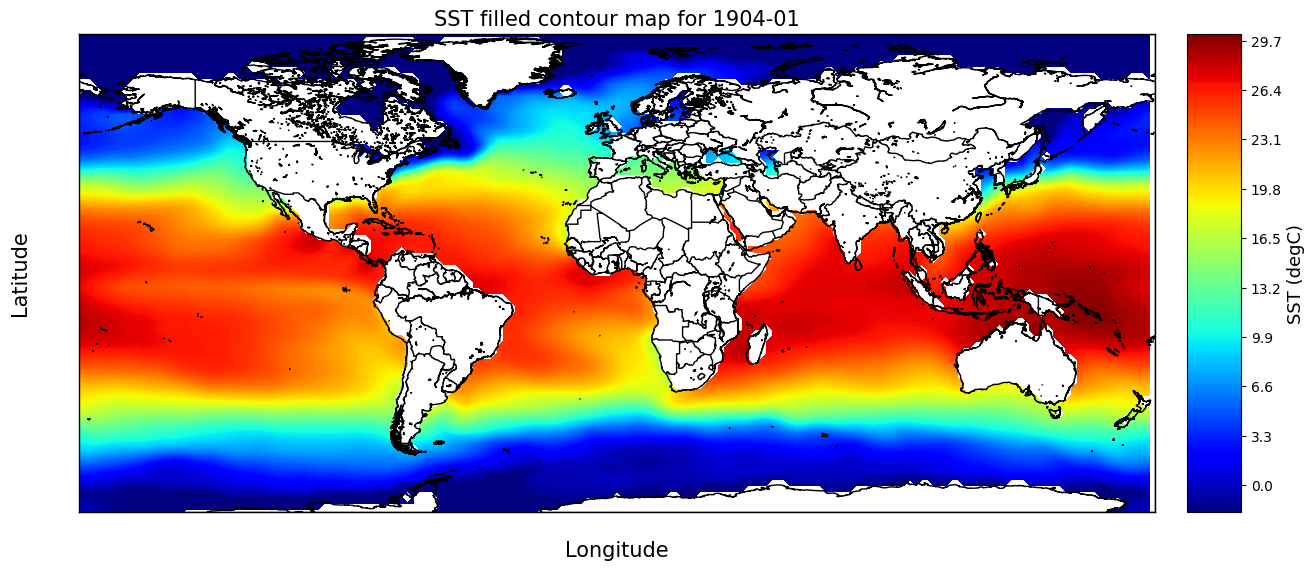

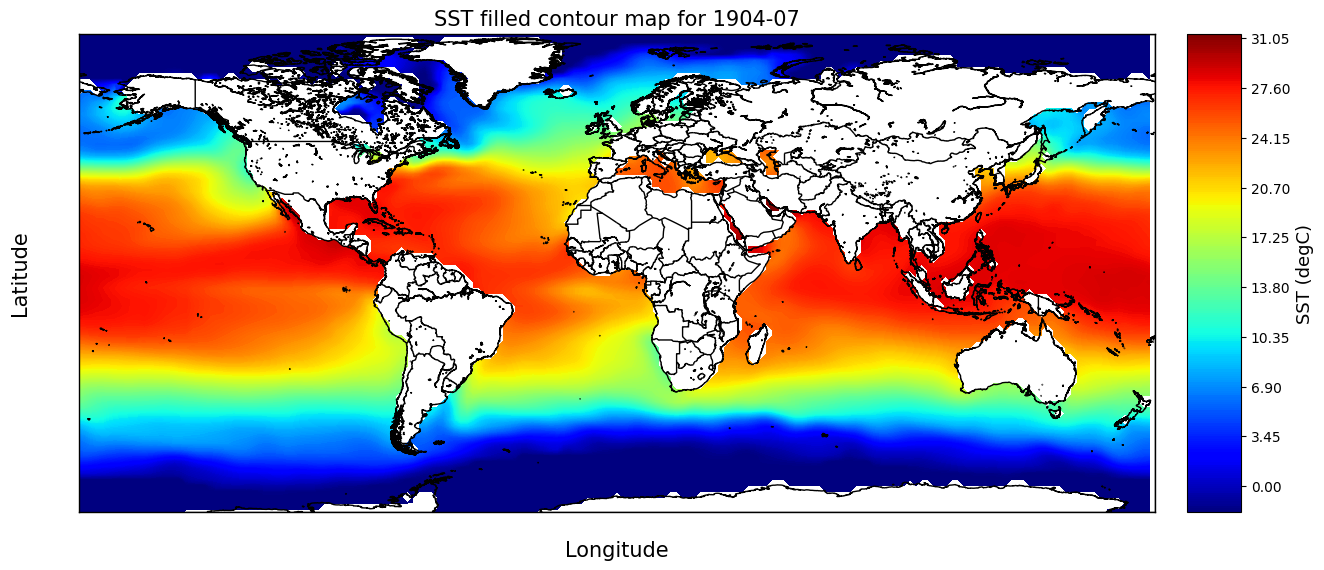

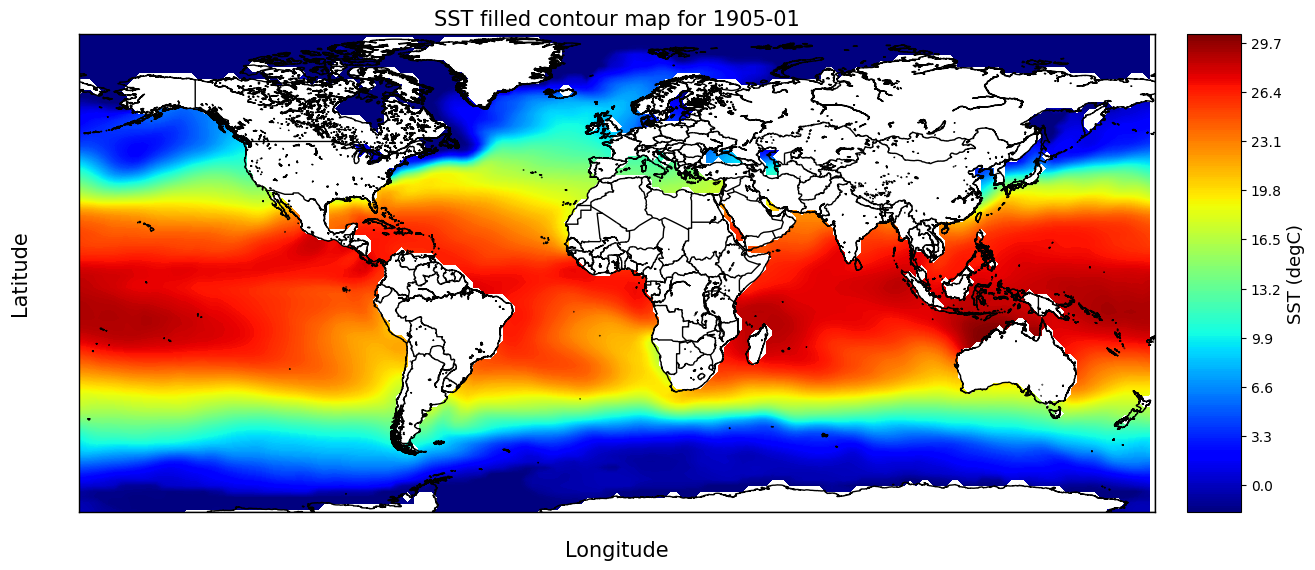

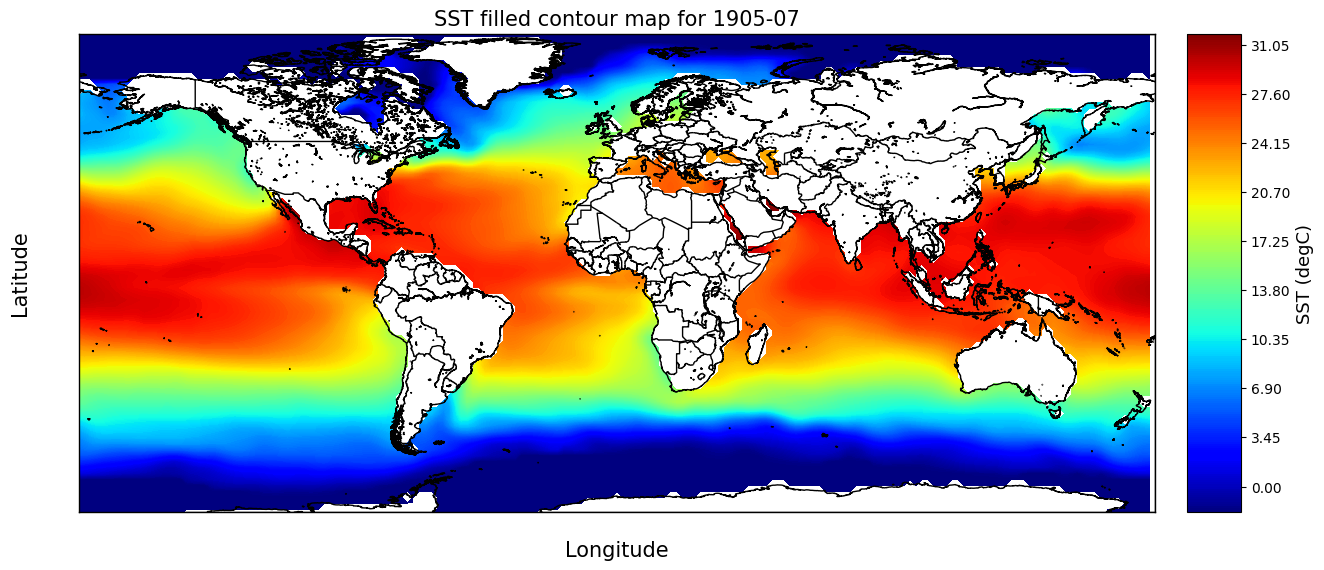

In [16]:
for date_index in range(12*50,12*50+12*2,6):
    SSTHelper.sst_basemap(ds, date_index)

## Obtendo 5 pontos no mar

Para o estudo aqui apresentado, foram elegidos 5 coordenadas de interesse no globo terrestre das quais serão extraídas as séries de SST. Essas séries são os artefatos de estudo do trabalho e para as quais foi realizada a tarefa de previsão.

* P1: Um ponto na região do ENSO;
 -> lat = 20°, lon = -132° (https://www.google.com.br/maps/place/20%C2%B000'00.0%22N+132%C2%B000'00.0%22W/@22.1775213,-151.1364928,3.87z/data=!4m4!3m3!8m2!3d20!4d-132?entry=ttu)

* P2: Um ponto na costa do Chile (Corrente de Humboldt);
 -> lat = -22°, lon = -72° (https://www.google.com.br/maps/place/22%C2%B000'00.0%22S+72%C2%B000'00.0%22W/@-21.7898533,-87.474343,4.04z/data=!4m4!3m3!8m2!3d-22!4d-72?entry=ttu)

* P3: Um ponto no meio do Mediterrâneo;
 -> lat = 36°, lon = 18° (https://www.google.com.br/maps/place/36%C2%B000'00.0%22N+18%C2%B000'00.0%22E/@36.0000043,17.9974251,17z/data=!3m1!4b1!4m4!3m3!8m2!3d36!4d18?entry=ttu)

* P4: Um ponto no meio do Atlântico;
 -> lat = 0°, lon = -22° (https://www.google.com.br/maps/place/0%C2%B000'00.0%22N+22%C2%B000'00.0%22W/@-11.0144452,-50.6148726,3z/data=!4m3!3m2!8m1!4d-22?entry=ttu)

* P5: Um ponto no extremo Índico (ponto de maior latitude, temperaturas mais baixas)
 -> lat = -56°, lon = 80° (https://www.google.com.br/maps/place/56%C2%B000'00.0%22S+80%C2%B000'00.0%22E/@-36.027701,54.6888129,3z/data=!4m4!3m3!8m2!3d-56!4d80?entry=ttu)

In [17]:
df

,index,lat,lon,time,nbnds,time_bnds,sst
0,0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
1,2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
2,4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8
3,6,88.0,0.0,1854-04-01,0,9.969210e+36,-1.8
4,8,88.0,0.0,1854-05-01,0,9.969210e+36,-1.8
...,...,...,...,...,...,...,...
32648755,65297510,-88.0,-2.0,2023-06-01,0,9.969210e+36,NaN
32648756,65297512,-88.0,-2.0,2023-07-01,0,9.969210e+36,NaN
32648757,65297514,-88.0,-2.0,2023-08-01,0,9.969210e+36,NaN
32648758,65297516,-88.0,-2.0,2023-09-01,0,9.969210e+36,NaN


In [18]:
df[(df['lat']==40) & (df['lon']==40)].shape

(2038, 7)

In [19]:
f = lambda x: ((x+180) % 360) - 180

Para facilitar a manipulação, foi adicionada uma coluna com a longitude convertida para o padrão do basemap. Esse padrão de coordenadas. Os valores de latitude variam $\in [-88, 88]$ e longitude $\in [0, 360]$ no conjunto de dados original e queremos converter a longitude de forma que longitude $\in [-180, 180]$.

In [20]:
df['lon'] = df['lon'].copy().apply(f)

In [21]:
df.sample(10)

,index,lat,lon,time,nbnds,time_bnds,sst
1773238,3546476,80.0,-60.0,1868-11-01,0,9.969210e+36,NaN
3229758,6459516,72.0,-72.0,1984-07-01,0,9.969210e+36,2.173615
1060663,2121326,84.0,-40.0,1929-04-01,0,9.969210e+36,-1.800000
9589986,19179972,36.0,50.0,1953-09-01,0,9.969210e+36,NaN
11137833,22275666,28.0,130.0,1867-08-01,0,9.969210e+36,28.356491
27992942,55985884,-64.0,110.0,1938-05-01,0,9.969210e+36,-1.800000
824998,1649996,84.0,88.0,1991-03-01,0,9.969210e+36,-1.800000
18237134,36474268,-10.0,-104.0,1946-07-01,0,9.969210e+36,24.083006
28149036,56298072,-64.0,-96.0,1869-01-01,0,9.969210e+36,2.489794
13052046,26104092,18.0,-152.0,1911-11-01,0,9.969210e+36,24.694723


In [22]:
p1 = SSTHelper.get_sst_series(df, 20, -132)
p2 = SSTHelper.get_sst_series(df, -22, -72)
p3 = SSTHelper.get_sst_series(df, 36, 18)
p4 = SSTHelper.get_sst_series(df, 0, -22)
p5 = SSTHelper.get_sst_series(df, -56, 80)


In [23]:
# Exemplo:
p1

,index,nbnds,time_bnds,sst
time,,,,
1854-01-01,25409784,0,9.969210e+36,22.197483
1854-02-01,25409786,0,9.969210e+36,21.905436
1854-03-01,25409788,0,9.969210e+36,22.155600
1854-04-01,25409790,0,9.969210e+36,22.680405
1854-05-01,25409792,0,9.969210e+36,22.942524
...,...,...,...,...
2023-06-01,25413850,0,9.969210e+36,22.585289
2023-07-01,25413852,0,9.969210e+36,22.950830
2023-08-01,25413854,0,9.969210e+36,24.066349


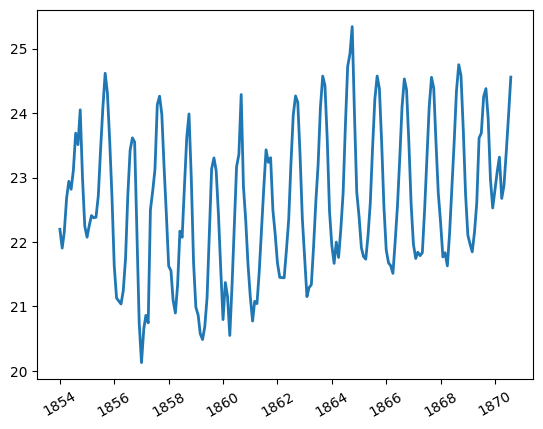

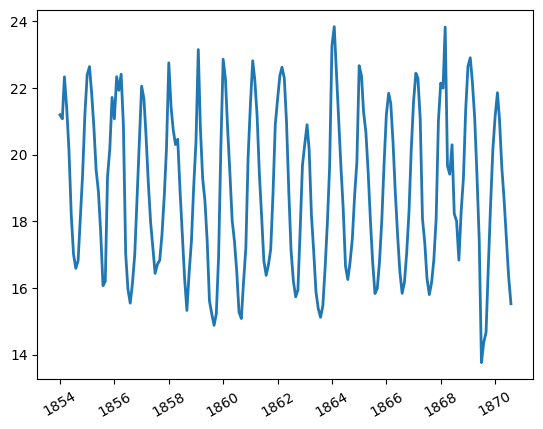

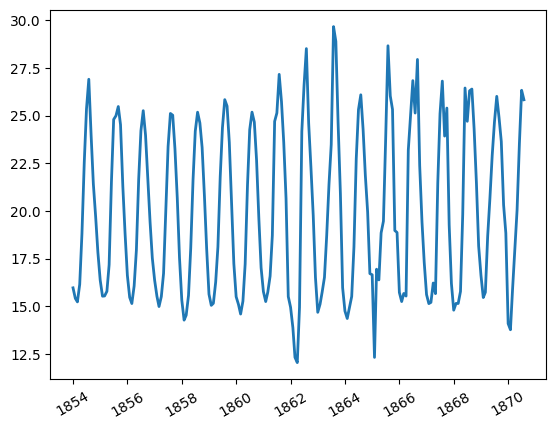

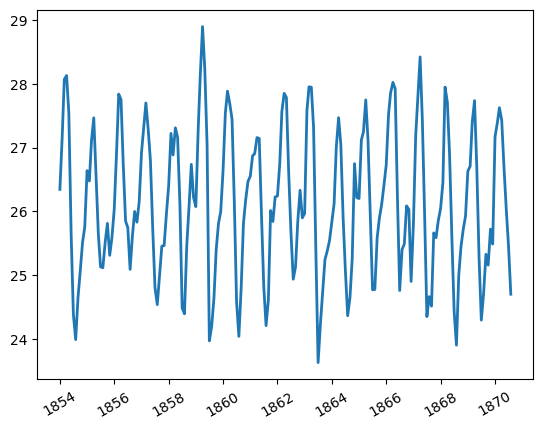

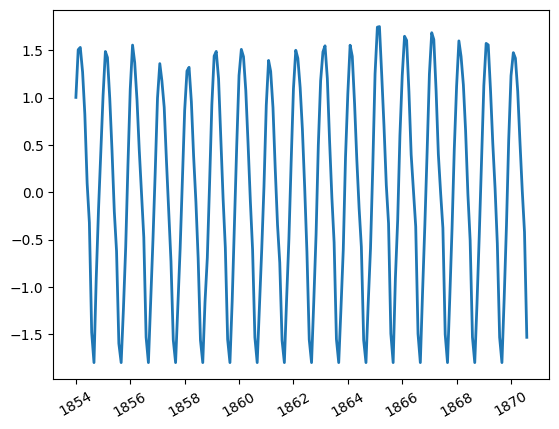

In [24]:
SSTHelper.plot_sst(p1, 0, 200)
SSTHelper.plot_sst(p2, 0, 200)
SSTHelper.plot_sst(p3, 0, 200)
SSTHelper.plot_sst(p4, 0, 200)
SSTHelper.plot_sst(p5, 0, 200)

#### Plotando os pontos no mapa da biblioteca


In [98]:
from netuno import SSTHelper

In [99]:
date_index_p1 = len(p1)-1
lats = [20, -22, 36, 0, -56]
lons = [SSTHelper.f(-132), SSTHelper.f(-72), SSTHelper.f(18), SSTHelper.f(-22), SSTHelper.f(80)]

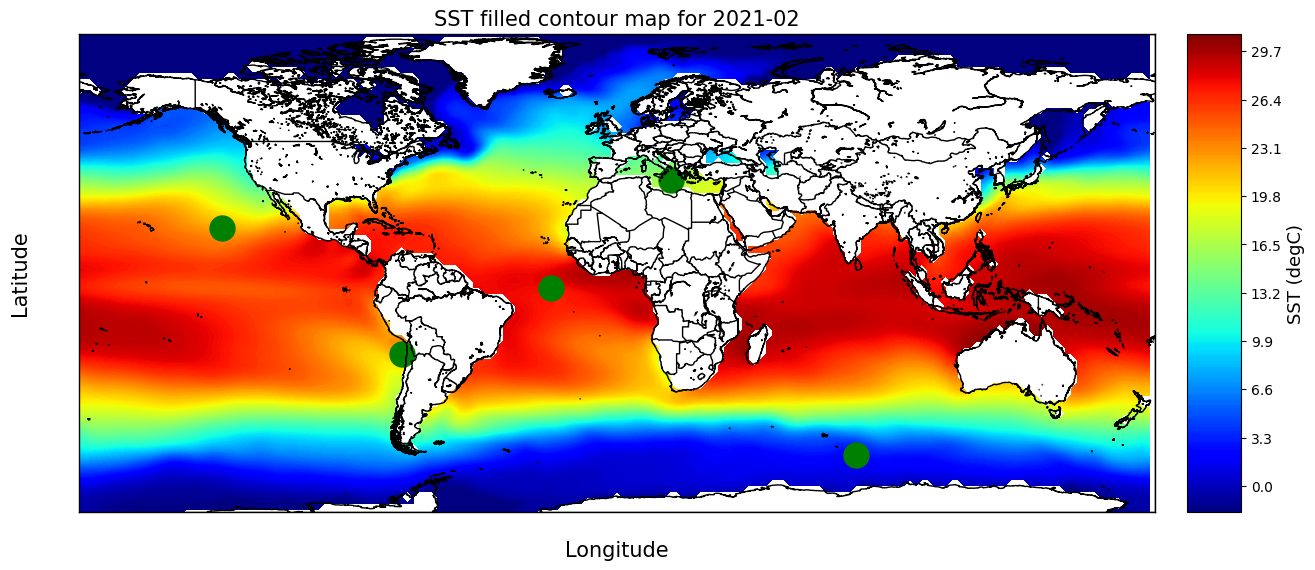

In [100]:
SSTHelper.sst_basemap_dot_ref(ds, date_index, lons, lats)